<a href="https://colab.research.google.com/github/chxnmay17/SPPU-ML-Laboratory/blob/main/pract4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- Successfully loaded 'Churn_Modelling.csv' ---
   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57   

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



--- Starting Model Training ---
Epoch 1/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5302 - loss: 0.7086 - val_accuracy: 0.8000 - val_loss: 0.5267
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7848 - loss: 0.5309 - val_accuracy: 0.8019 - val_loss: 0.4412
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8016 - loss: 0.4665 - val_accuracy: 0.8194 - val_loss: 0.4049
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8114 - loss: 0.4348 - val_accuracy: 0.8338 - val_loss: 0.3872
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8202 - loss: 0.4207 - val_accuracy: 0.8537 - val_loss: 0.3753
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8272 - loss: 0.4031 - val_accuracy: 0.8569 - val_loss: 0.3667
Epoch 7/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8247 - loss: 0.4008 - val_accuracy: 0.8606 - val_loss: 0.3639
Epoch 8/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy:

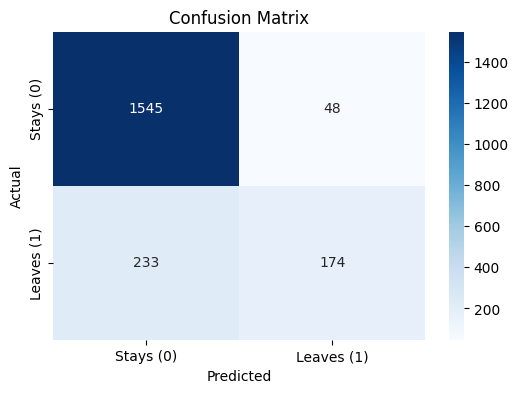

In [1]:
# -----------------------------------------------------------------
# STEP 0: IMPORT LIBRARIES
# -----------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# -----------------------------------------------------------------
# STEP 1: READ THE DATASET
# -----------------------------------------------------------------
try:
    df = pd.read_csv('Churn_Modelling.csv')
    print("--- Successfully loaded 'Churn_Modelling.csv' ---")
    print(df.head())
except FileNotFoundError:
    print("Error: 'Churn_Modelling.csv' not found.")
    print("Please make sure you have uploaded the file using the 'Files' icon in the left sidebar.")
    raise

# -----------------------------------------------------------------
# STEP 2: DISTINGUISH FEATURE/TARGET & SPLIT DATA
# -----------------------------------------------------------------

# Features (X): Drop irrelevant columns and the target column
# RowNumber, CustomerId, and Surname are not useful for prediction.
X = df.drop(columns=['RowNumber', 'CustomerId', 'Surname', 'Exited'])

# Target (y): 'Exited' column (1 if they left, 0 if they stayed)
y = df['Exited']

# Split into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

# -----------------------------------------------------------------
# STEP 3: NORMALIZE AND PREPROCESS DATA
# -----------------------------------------------------------------

# Identify numerical and categorical columns
numerical_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
categorical_cols = ['Geography', 'Gender']

# Create transformers
# StandardScaler for numerical features
numerical_transformer = StandardScaler()
# OneHotEncoder for categorical features (converts them to numbers)
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Use ColumnTransformer to apply different transformers to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='passthrough' # Keep 'HasCrCard' and 'IsActiveMember' as they are (already 0/1)
)

# Apply the preprocessing
# FIT and TRANSFORM on the training data
X_train_processed = preprocessor.fit_transform(X_train)

# ONLY TRANSFORM on the test data (to prevent data leakage)
X_test_processed = preprocessor.transform(X_test)

print("\n--- Data successfully preprocessed and normalized ---")

# -----------------------------------------------------------------
# STEP 4: INITIALIZE AND BUILD THE MODEL (WITH IMPROVEMENTS)
# -----------------------------------------------------------------

# Get the number of input features after preprocessing
# This will be 6 (numerical) + 3 (Geography) + 2 (Gender) + 2 (passthrough) = 13
input_dim = X_train_processed.shape[1]
print(f"Number of input features to the model: {input_dim}")

# --- Initialize the ANN ---
model = Sequential()

# --- Build the Model ---
# Input Layer and First Hidden Layer
model.add(Dense(12, input_dim=input_dim, activation='relu'))

# Second Hidden Layer
model.add(Dense(8, activation='relu'))

# --- Point of Improvement 1: Dropout ---
# Add Dropout to prevent overfitting. It randomly "turns off"
# 30% of neurons during training to make the model more robust.
model.add(Dropout(0.3))

# Output Layer
# 1 neuron because this is a binary (Yes/No) problem
# 'sigmoid' activation to output a probability between 0 and 1
model.add(Dense(1, activation='sigmoid'))

# --- Compile the Model ---
# 'adam' is an efficient optimizer
# 'binary_crossentropy' is the standard loss function for binary classification
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# --- Point of Improvement 2: Early Stopping ---
# This callback monitors the validation loss and stops training
# if it doesn't improve for 10 epochs. It also restores
# the weights from the "best" epoch.
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# --- Train the Model ---
print("\n--- Starting Model Training ---")
history = model.fit(
    X_train_processed,
    y_train,
    validation_split=0.2,  # Use 20% of training data for validation
    epochs=100,            # Max epochs
    batch_size=32,
    callbacks=[early_stop], # Apply early stopping
    verbose=1
)

print("\n--- Model Training Complete ---")

# -----------------------------------------------------------------
# STEP 5: PRINT ACCURACY SCORE AND CONFUSION MATRIX
# -----------------------------------------------------------------

# Make predictions on the test set
y_pred_probs = model.predict(X_test_processed)
# Convert probabilities (e.g., 0.8) into classes (1) using a 0.5 threshold
y_pred = (y_pred_probs > 0.5).astype(int)

# --- Accuracy Score ---
accuracy = accuracy_score(y_test, y_pred)
print("\n================= Model Performance ==================")
print(f"Test Accuracy: {accuracy:.4f}")

# --- Classification Report ---
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Stays (0)', 'Leaves (1)']))

# --- Confusion Matrix ---
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Stays (0)', 'Leaves (1)'],
            yticklabels=['Stays (0)', 'Leaves (1)'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()